## Import Packages And Define Functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

#### Import TALib Only If Necessary

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4420    0  4420    0     0  20896      0 --:--:-- --:--:-- --:--:-- 20947
100  517k  100  517k    0     0  1153k      0 --:--:-- --:--:-- --:--:-- 1153k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4384    0  4384    0     0  20517      0 --:--:-- --:--:-- --:--:-- 20582
100  392k  100  392k    0     0   804k      0 --:--:-- --:--:-- --:--:--  804k


In [ ]:
def annual_num_transaction(position):
    return sum(np.where(position != position.shift(1), 1, 0)) / len(position) * 252.

def annual_return(returns):
    return returns.mean() * 252.

def annual_volatility(returns):
    return returns.std() * (252. ** 0.5)

def cum_return(returns):
    return list(np.exp(returns.cumsum()))[-1]

def max_drawdown(returns):
    cum_returns = np.exp(returns.cumsum())
    cum_max = cum_returns.cummax()
    return ((cum_max - cum_returns) / cum_max).max()

def information_ratio(strategy_return, benchmark_return):
    track_error = annual_volatility(strategy_return - benchmark_return)
    if track_error < 1e-9:
        return 0.
    else:
        return (annual_return(strategy_return) - annual_return(benchmark_return)) / track_error

## Data Cleaning

In [ ]:
!pip install yfinance
import yfinance as yf

In [ ]:
code = [
    "^GSPC",
    "AAPL",
    "JPM",
    "GOOGL",
    "000300.SS", #HS300
    "600887.SS", #YLGF
    "600519.SS", #GZMT
    "600897.SS", #XMKG
    "601601.SS", #ZGTB
    "600188.SS", #YKNY
    "601318.SS", #ZGPA
    "600900.SS", #CJDL
    "600000.SS", #PFYH
    "002460.SZ", #GFLY
]
data_train = yf.download("^GSPC", start = "2007-01-01", end = "2023-01-01", auto_adjust = False)
data_train["close"] = data_train["Adj Close"]
data_train["open"] = data_train["Open"]
data_train["high"] = data_train["High"]
data_train["low"] = data_train["Low"]
data_train["return"] = np.log(data_train["close"] / data_train["close"].shift(1))
data_test = yf.download("^GSPC", start = "2022-01-01", auto_adjust = False)
data_test["close"] = data_test["Adj Close"]
data_test["open"] = data_test["Open"]
data_test["high"] = data_test["High"]
data_test["low"] = data_test["Low"]
data_test["return"] = np.log(data_test["close"] / data_test["close"].shift(1))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Strategy

In [ ]:
short_windows = [5, 12, 20]
long_windows = [26, 65, 120]
signal_windows = [2, 5, 9]
up_stds = [0., 0.5, 1.]
down_stds = [0., 0.5, 1.]
transaction_cost = 0.
# max history data needed
look_back_window = 365
# backtest for 24 months
backtest_length = 365 * 2
backtest_launch_points = [
    # "2007-12-31",
    # "2009-12-31",
    # "2011-12-31",
    "2013-12-31",
    "2016-12-31",
    "2019-12-31",
    "2021-12-31",
    ]
performance = pd.DataFrame(columns = ["short_window",
                                      "long_window",
                                      "signal_window",
                                      "up_std",
                                      "down_std",
                                      "launch_point",
                                      "num_transaction_per_year",
                                      "annual_return",
                                      "annual_vol",
                                      "cum_return",
                                      "max_drawdown",
                                      "information_ratio"
                                      ])
for launch_point in backtest_launch_points:
    new_row = pd.DataFrame({
        "short_window": 0,
        "long_window": 0,
        "signal_window": 0,
        "up_std": 0,
        "down_std": 0,
        "launch_point": launch_point,
        "num_transaction_per_year": 0,
        "annual_return": annual_return(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "annual_vol": annual_volatility(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "cum_return": cum_return(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "max_drawdown": max_drawdown(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "information_ratio": 0
        }, index = [0])
    performance = pd.concat([performance, new_row], ignore_index = True)

In [ ]:
def MACD(short_window, long_window, signal_window, up_std, down_std, df, launch_point, look_back_window, backtest_length, launch_position):
    dataframe = df.copy(deep = True)
    dataframe = dataframe[(pd.to_datetime(launch_point) - pd.to_timedelta(look_back_window, unit = "d")):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]
    dataframe[f"position_strategy"] = launch_position
    dataframe[f"EMA_{short_window}"] = dataframe["close"].ewm(short_window).mean()
    dataframe[f"EMA_{long_window}"] = dataframe["close"].ewm(long_window).mean()
    dataframe[f"DIF"] = dataframe[f"EMA_{short_window}"] - dataframe[f"EMA_{long_window}"]
    dataframe[f"DEA"] = dataframe["DIF"].ewm(signal_window).mean()
    dataframe[f"MACD"] = dataframe["DIF"] - dataframe["DEA"]
    dataframe[f"MACD_std"] = dataframe["MACD"].rolling(signal_window).std()
    # set index to be 0, 1, 2, ...
    dataframe["date"] = dataframe.index
    dataframe.index = range(len(dataframe))
    # for static stop loss
    open_price = 0.
    # when launch point is not a business day
    while len(dataframe[dataframe["date"] == launch_point].index.values) == 0:
        launch_point = str(pd.to_datetime(launch_point) + pd.to_timedelta(1, unit = "d"))
    launch_point_index = dataframe[dataframe["date"] == launch_point].index.values[0]
    # add extra row for forecast purpose
    last_date = pd.to_datetime(dataframe.loc[len(dataframe) - 1, "date"])
    dataframe.loc[len(dataframe), "date"] = last_date + pd.to_timedelta(1, unit = "d")
    # strategy logic
    for i in range(launch_point_index + 1, len(dataframe)):
        if dataframe.loc[i - 1, f"position_strategy"] == 0:
            if dataframe.loc[i - 1, f"MACD"] > 0. + up_std * dataframe.loc[i - 1, f"MACD_std"]:
                dataframe.loc[i, f"position_strategy"] = 1
                open_price = dataframe.loc[i, "open"]
            else:
                dataframe.loc[i, f"position_strategy"] = dataframe.loc[i - 1, f"position_strategy"]
        else:
            if dataframe.loc[i - 1, f"MACD"] < 0. - down_std * dataframe.loc[i - 1, f"MACD_std"]\
            | (((dataframe.loc[i - 1, f"close"] -  dataframe.loc[i - 2, f"close"]) / dataframe.loc[i - 2, f"close"]) < -0.05)\
            | (((dataframe.loc[i - 1, f"close"] -  dataframe.loc[i - 6, f"close"]) / dataframe.loc[i - 6, f"close"]) < -0.3):
                dataframe.loc[i, f"position_strategy"] = 0
                open_price = 0.
            else:
                dataframe.loc[i, f"position_strategy"] = dataframe.loc[i - 1, f"position_strategy"]
    dataframe[f"return_strategy"] = dataframe[f"position_strategy"] * dataframe["return"]
    # set index back to date
    dataframe.set_index("date", inplace = True)
    dataframe_drop = dataframe[(pd.to_datetime(launch_point) + pd.to_timedelta(1, unit = "d")):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]
    return dataframe_drop

## Train

In [ ]:
for short_window in short_windows:
    for long_window in long_windows:
        for signal_window in signal_windows:
            for up_std in up_stds:
                for down_std in down_stds:
                    for launch_point in backtest_launch_points:
                        output_train = MACD(short_window, long_window, signal_window, up_std, down_std, data_train, launch_point, look_back_window, backtest_length, 0)
                        # drop the added last row
                        output_train = output_train.dropna()
                        new_row = pd.DataFrame({
                            "short_window": short_window,
                            "long_window": long_window,
                            "signal_window": signal_window,
                            "up_std": up_std,
                            "down_std": down_std,
                            "launch_point": launch_point,
                            "num_transaction_per_year": annual_num_transaction(output_train[f"position_strategy"]),
                            "annual_return": annual_return(output_train[f"return_strategy"]),
                            "annual_vol": annual_volatility(output_train[f"return_strategy"]),
                            "cum_return": cum_return(output_train[f"return_strategy"]),
                            "max_drawdown": max_drawdown(output_train[f"return_strategy"]),
                            "information_ratio": information_ratio(output_train[f"return_strategy"], output_train["return"])
                        }, index = [0])
                        performance = pd.concat([performance, new_row], ignore_index = True)

In [ ]:
# calculate average information ration through all bt launch points
tmp = pd.DataFrame(columns = ["short_window",
                              "long_window",
                              "signal_window",
                              "up_std",
                              "down_std",
                              "avg_information_ratio"
                              ])
for short_window in short_windows:
    for long_window in long_windows:
        for signal_window in signal_windows:
            for up_std in up_stds:
                for down_std in down_stds:
                    new_row = pd.DataFrame({
                        "short_window": short_window,
                        "long_window": long_window,
                        "signal_window": signal_window,
                        "up_std": up_std,
                        "down_std": down_std,
                        "avg_information_ratio": performance[(performance["short_window"] == short_window) &
                        (performance["long_window"] == long_window) &
                        (performance["signal_window"] == signal_window) &
                        (performance["up_std"] == up_std) &
                        (performance["down_std"] == down_std)][["information_ratio"]].mean().values[0]
                        }, index = [0])
                    tmp = pd.concat([tmp, new_row], ignore_index = True)
performance = pd.merge(performance, tmp, on = ["short_window", "long_window", "signal_window", "up_std", "down_std"], how = "left")

In [ ]:
performance.sort_values(by = ["avg_information_ratio", "short_window", "long_window", "signal_window", "up_std", "down_std", "launch_point"], ascending = False)

,short_window,long_window,signal_window,up_std,down_std,launch_point,num_transaction_per_year,annual_return,annual_vol,cum_return,max_drawdown,information_ratio,avg_information_ratio
263,5,120,5,0.0,0.5,2021-12-31,9.371901,0.125239,0.319929,1.127801,0.195626,1.469051,0.511071
262,5,120,5,0.0,0.5,2019-12-31,8.313402,0.877971,0.488848,5.418107,0.275251,0.395677,0.511071
261,5,120,5,0.0,0.5,2016-12-31,10.91134,0.254927,0.379159,1.633349,0.389295,0.368538,0.511071
260,5,120,5,0.0,0.5,2013-12-31,10.347826,0.924030,0.537230,4.563318,0.345734,-0.188983,0.511071
171,5,65,5,0.5,1.0,2021-12-31,7.289256,0.158763,0.318405,1.164699,0.203037,1.559346,0.505910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,5,26,2,0.0,0.5,2013-12-31,19.478261,0.635551,0.522722,2.840897,0.445545,-0.786341,-0.065072
3,0,0,0,0,0,2021-12-31,0,-0.354596,0.476513,0.710397,0.389154,0,NaN
2,0,0,0,0,0,2019-12-31,0,0.715268,0.650704,3.972699,0.407619,0,NaN
1,0,0,0,0,0,2016-12-31,0,0.121853,0.523922,1.264911,0.663303,0,NaN


## Backtest

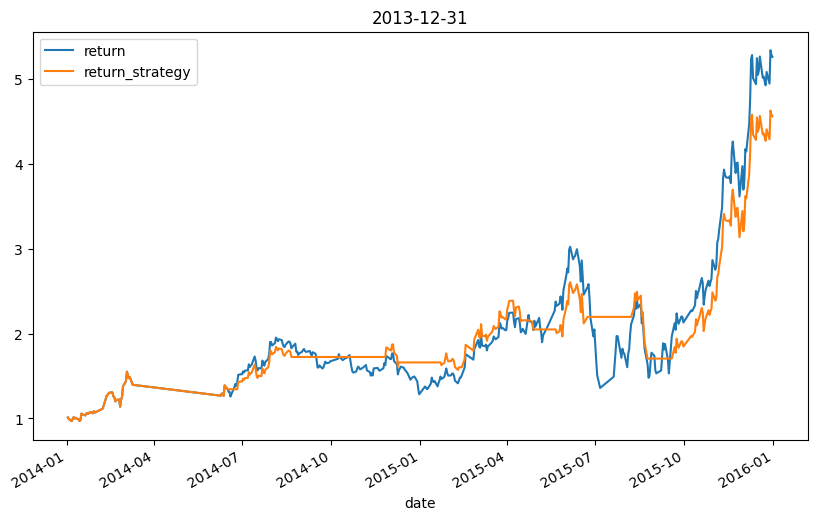

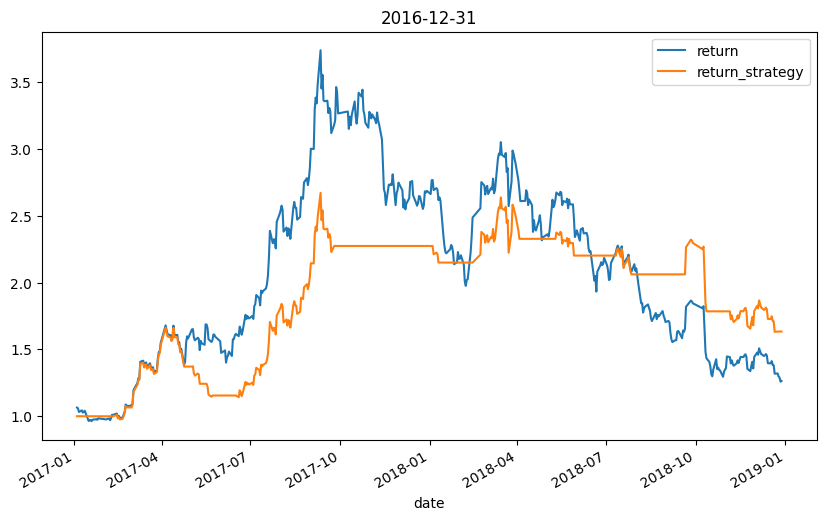

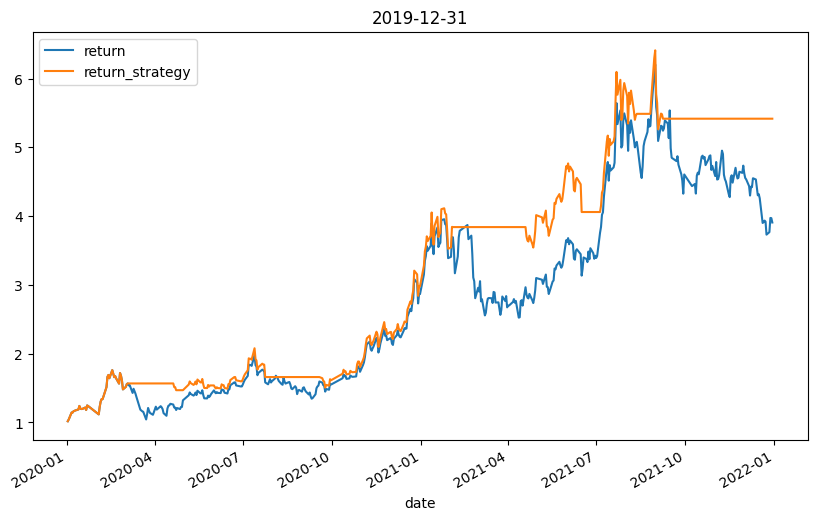

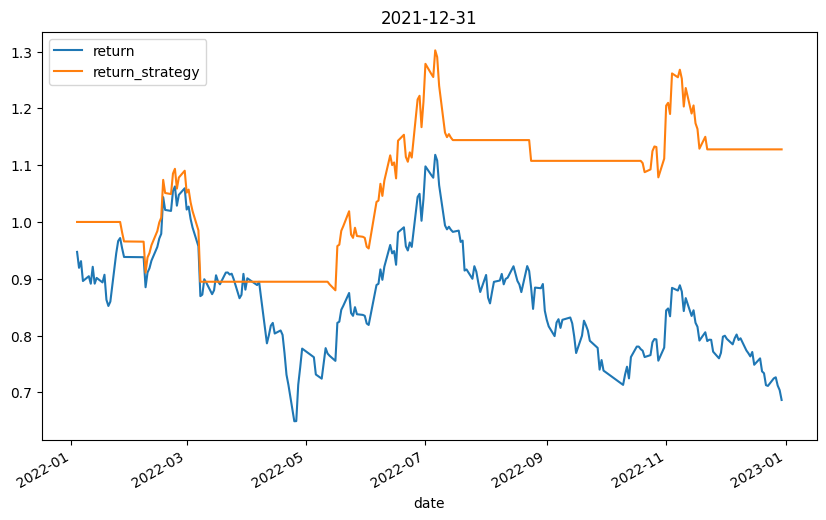

In [ ]:
# short_window, long_window, signal_window, up_std, down_std = 5, 26, 2, 0.5, 0.5 #GSPC
# short_window, long_window, signal_window, up_std, down_std = 12, 120, 9, 0.5, 0.5 #YLGF
short_window, long_window, signal_window, up_std, down_std = 5, 120, 5, 0.0, 0.5 #GFLY
for launch_point in backtest_launch_points:
    output_backtest = MACD(short_window, long_window, signal_window, up_std, down_std, data_train, launch_point, look_back_window, backtest_length, 0)
    # drop the added last row
    output_backtest = output_backtest.dropna()
    output_backtest[["return", f"return_strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 6), title = launch_point)
    # output_backtest[["open_price"]].plot(figsize=(10, 6))
    # output_backtest[f"position_strategy"].plot(secondary_y = True, legend = "position")
    # output_backtest[["close"]].plot(secondary_y = True, legend = "close")

## Forecast

In [ ]:
# short_window, long_window, signal_window, up_std, down_std = 5, 26, 2, 0.5, 0.5 #GSPC
# short_window, long_window, signal_window, up_std, down_std = 12, 120, 9, 0.5, 0.5 #YLGF
short_window, long_window, signal_window, up_std, down_std = 5, 120, 5, 0.0, 0.5 #GFLY
launch_point = "2023-01-01"
# launch_point = "2024-03-01" #GSPC
# launch_point = "2024-03-06" #YLGF
# launch_point = "2024-02-25" #GFLY
output_test = MACD(short_window, long_window, signal_window, up_std, down_std, data_test, launch_point, look_back_window, backtest_length, 0)
new_row = {
    "short_window": short_window,
    "long_window": long_window,
    "signal_window": signal_window,
    "up_std": up_std,
    "down_std": down_std,
    "launch_point": launch_point,
    "num_transaction_per_year": annual_num_transaction(output_test[f"position_strategy"]),
    "annual_return": annual_return(output_test[f"return_strategy"]),
    "annual_vol": annual_volatility(output_test[f"return_strategy"]),
    "cum_return": cum_return(output_test[f"return_strategy"]),
    "max_drawdown": max_drawdown(output_test[f"return_strategy"]),
    "information_ratio": information_ratio(output_test[f"return_strategy"], output_test["return"])
}

In [ ]:
new_row

{'short_window': 5,
 'long_window': 120,
 'signal_window': 5,
 'up_std': 0.0,
 'down_std': 0.5,
 'launch_point': '2023-01-01',
 'num_transaction_per_year': 17.439446366782008,
 'annual_return': -0.5484096926590799,
 'annual_vol': 0.26622452005654396,
 'cum_return': nan,
 'max_drawdown': 0.555508091099742,
 'information_ratio': -0.17939527125260582}

<Axes: >

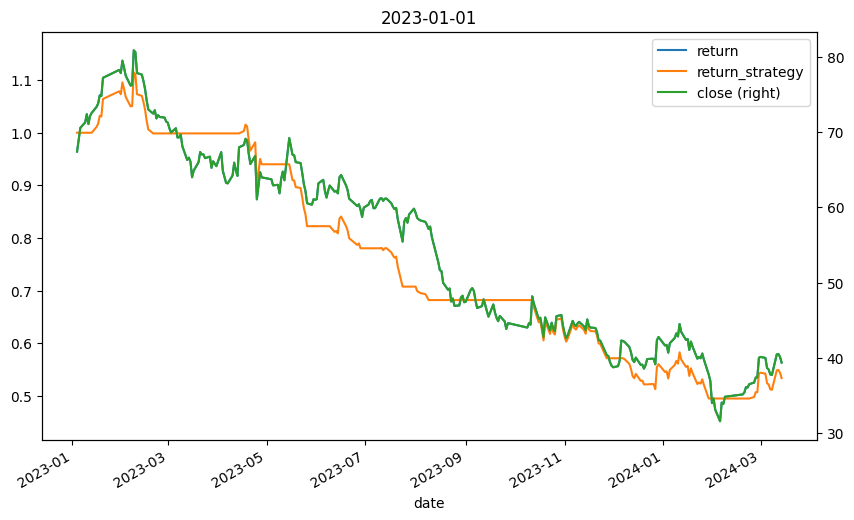

In [ ]:
output_test[["return", f"return_strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 6), title = launch_point)
# output_test[["close", f"SMA_{short_term}", f"SMA_{long_term}"]].plot(figsize=(10, 6))
# output_test[f"position_strategy"].plot(secondary_y = True, legend = "position")
output_test["close"].plot(secondary_y = True, legend = "close")

In [ ]:
output_test.tail(10)

,open,close,high,low,volume,code,return,position_strategy,EMA_5,EMA_120,DIF,DEA,MACD,MACD_std,return_strategy
date,,,,,,,,,,,,,,,
2024-03-04,40.43,40.02,41.35,39.71,361729.0,002460,-0.003492,1.0,37.953661,50.596522,-12.642861,-14.285337,1.642476,0.491392,-0.003492
2024-03-05,39.50,38.69,39.57,38.50,289938.0,002460,-0.033798,1.0,38.076384,50.496832,-12.420448,-13.974522,1.554074,0.392132,-0.033798
2024-03-06,38.27,38.49,39.01,37.95,215003.0,002460,-0.005183,1.0,38.145320,50.396314,-12.250994,-13.687267,1.436273,0.186314,-0.005183
2024-03-07,38.79,37.83,39.10,37.80,221647.0,002460,-0.017296,1.0,38.092767,50.291123,-12.198356,-13.439116,1.240759,0.150412,-0.017296
2024-03-08,37.82,37.76,38.50,37.40,191186.0,002460,-0.001852,1.0,38.037306,50.186238,-12.148932,-13.224085,1.075153,0.231412,-0.001852
2024-03-11,38.25,40.48,40.68,38.25,500517.0,002460,0.069558,1.0,38.444421,50.105005,-11.660584,-12.963501,1.302918,0.183585,0.069558
2024-03-12,41.38,40.55,41.60,40.08,368945.0,002460,0.001728,1.0,38.795351,50.025047,-11.229696,-12.674534,1.444838,0.152989,0.001728
2024-03-13,40.60,40.16,40.89,39.93,214535.0,002460,-0.009664,1.0,39.022793,49.942502,-10.919710,-12.382063,1.462353,0.159119,-0.009664
2024-03-14,40.01,39.41,40.68,39.13,262197.0,002460,-0.018852,1.0,39.087327,49.854382,-10.767055,-12.112895,1.345840,0.155375,-0.018852
